In [1]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from string import punctuation

In [2]:
my_stem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n'

# Import and clean data

In [3]:
df = pd.read_csv('D:/loan_nar.csv')

In [4]:
#clean the column names
lis = []
for name in df.columns:
    name = re.sub('[^a-zA-Z0-9]+', "_", name)
    lis.append(name)
    
df.columns = lis

In [5]:
df.shape

(150676, 19)

In [6]:
df_loan = df[df['Issue'] == "Incorrect information on your report"]

In [7]:
df_loan['Sub_issue'].value_counts()

Information belongs to someone else                    32365
Account status incorrect                               14796
Account information incorrect                          14466
Old information reappears or never goes away            4195
Personal information incorrect                          4068
Public record information inaccurate                    3873
Information is missing that should be on the report     1681
Information is incorrect                                 298
Information that should be on the report is missing       57
Name: Sub_issue, dtype: int64

In [8]:
df_loan = df_loan[df_loan['Sub_issue'] != 'Information is incorrect']
df_loan['Sub_issue'][df_loan['Sub_issue'] == 'Information that should be on the report is missing'] = "Information is missing that should be on the report"

In [9]:
df_loan['Sub_issue'].value_counts()

Information belongs to someone else                    32365
Account status incorrect                               14796
Account information incorrect                          14466
Old information reappears or never goes away            4195
Personal information incorrect                          4068
Public record information inaccurate                    3873
Information is missing that should be on the report     1738
Name: Sub_issue, dtype: int64

In [10]:
df_loan.shape

(75502, 19)

In [11]:
df_loan = df_loan[df_loan['Sub_issue'].notna()]

In [12]:
df_loan.shape

(75501, 19)

In [13]:
df_loan_sample, df_drop_it = train_test_split(df_loan, train_size =0.3, stratify=df_loan['Sub_issue'])

In [14]:
df_clean = pd.DataFrame()

for x in df_loan_sample.Consumer_complaint_narrative:
    x_clean = re.sub('[^a-zA-Z]+', ' ', x)
    x_clean = re.sub('XXXX', '', x_clean)
    x_clean = re.sub('XX/XX', "", x_clean)
    x_clean = re.sub('XX/XX/', "", x_clean)
    x_clean = re.sub('XXX', "", x_clean)
    x_clean = re.sub('XX', "", x_clean)
    text = [word.lower() for word in x_clean.split()]
    text = [word for word in text if word not in stop_words]
    long_words=[]
    for i in text:
        if len(i)>1:                    
            long_words.append(i)   
    text = [my_stem.lemmatize(word) for word in long_words]
    join = " ".join(text)
    df_clean = df_clean.append({"body_stem" : text, "body" : join}, ignore_index=True)

In [15]:
df_clean['sub_issue'] = list(df_loan_sample.Sub_issue)
df_clean['timely_response'] = list(df_loan_sample.Timely_response_)
df_clean['issue'] = list(df_loan_sample.Issue)
df_clean['sub_product'] = list(df_loan_sample.Sub_product)
df_clean.head()

,body,body_stem,sub_issue,timely_response,issue,sub_product
0,another issue northern trust co trust account ...,"[another, issue, northern, trust, co, trust, a...",Information belongs to someone else,Yes,Incorrect information on your report,Other personal consumer report
1,submitted complaint general motor financial co...,"[submitted, complaint, general, motor, financi...",Information belongs to someone else,Yes,Incorrect information on your report,Credit reporting
2,block except otherwise provided section consum...,"[block, except, otherwise, provided, section, ...",Information belongs to someone else,Yes,Incorrect information on your report,Credit reporting
3,reporting late day late number came completely...,"[reporting, late, day, late, number, came, com...",Account status incorrect,Yes,Incorrect information on your report,Credit reporting
4,called creditor agreed remove account profile ...,"[called, creditor, agreed, remove, account, pr...",Information belongs to someone else,Yes,Incorrect information on your report,Credit reporting


In [16]:
df_clean.shape

(22650, 6)

# Logit model

In [17]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [18]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from collections import Counter

Using TensorFlow backend.


In [19]:
tfidf_vect = TfidfVectorizer() #analyzer='word', token_pattern=r'\w{1,}', max_features=5000
tfidf_vect.fit(df_clean.body) 
x = tfidf_vect.transform(df_clean.body)

In [20]:
enc = preprocessing.LabelEncoder() 
y = enc.fit_transform(df_clean.sub_issue)

In [21]:
print(enc.classes_)

['Account information incorrect' 'Account status incorrect'
 'Information belongs to someone else'
 'Information is missing that should be on the report'
 'Old information reappears or never goes away'
 'Personal information incorrect' 'Public record information inaccurate']


In [22]:
oversample = SVMSMOTE()
X, Y = oversample.fit_resample(x, y)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=0,shuffle=True)

In [24]:
counter = Counter(Y)
print(counter)

Counter({2: 9709, 1: 9709, 0: 9709, 5: 9709, 4: 9709, 6: 9709, 3: 9709})


In [25]:
model = LogisticRegression()
lr_params = {'C':[int(x) for x in np.linspace(1,10,10)]}
model_lr = GridSearchCV(estimator=model, param_grid=lr_params, cv=5, n_jobs=-1)
model_lr.fit(x_train, y_train)

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
print(model_lr.best_params_)
print(model_lr.best_score_)

{'C': 10}
0.8860768806327017


In [27]:
final_lr = LogisticRegression(C=10)
final_lr.fit(x_train, y_train)

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
final_lr_predict = final_lr.predict(x_test)
lr_accuracy = metrics.accuracy_score(final_lr_predict, y_test)
print ("Logistic Regression > Accuracy: ", lr_accuracy)

Logistic Regression > Accuracy:  0.8894283822555727


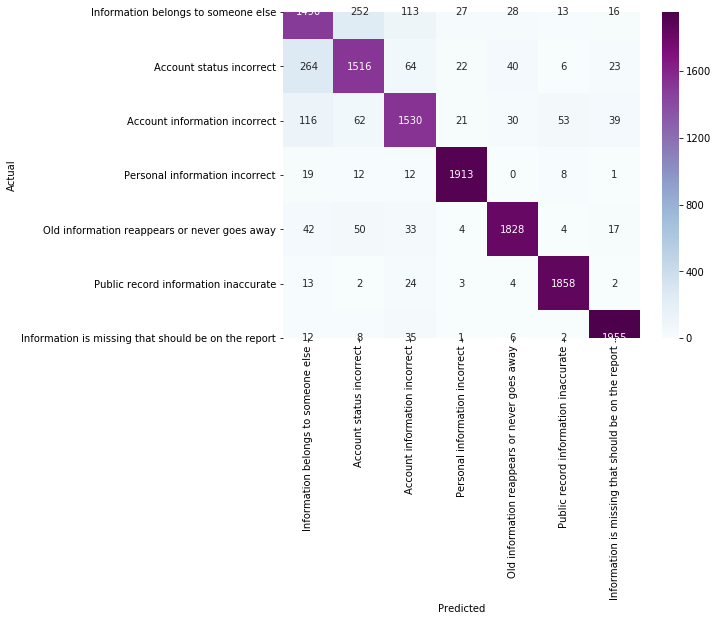

In [29]:
conf_mat = confusion_matrix(y_test, final_lr_predict)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(conf_mat, annot = True, fmt = "d", cmap = "BuPu",xticklabels = df_clean['sub_issue'].unique(),yticklabels = df_clean['sub_issue'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [30]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
print(sklearn.metrics.classification_report(y_test, final_lr_predict.round(),target_names=df_clean['sub_issue'].unique()))

                                                     precision    recall  f1-score   support

                Information belongs to someone else       0.76      0.77      0.77      1939
                           Account status incorrect       0.80      0.78      0.79      1935
                      Account information incorrect       0.84      0.83      0.84      1851
                     Personal information incorrect       0.96      0.97      0.97      1965
       Old information reappears or never goes away       0.94      0.92      0.93      1978
               Public record information inaccurate       0.96      0.97      0.97      1906
Information is missing that should be on the report       0.95      0.97      0.96      2019

                                           accuracy                           0.89     13593
                                          macro avg       0.89      0.89      0.89     13593
                                       weighted avg       0.89      

# SVM

In [31]:
model1 = LinearSVC()
svc_params = {'C':[0.01,0.1, 1, 10, 100]}
model_svc = GridSearchCV(estimator = model1,param_grid = svc_params, cv = 5, n_jobs = -1)
model_svc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [32]:
print(model_svc.best_params_)
print(model_svc.best_score_)

{'C': 10}
0.9074857458157073


In [33]:
final_svc = LinearSVC(C = 10)
final_svc.fit(x_train, y_train)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [34]:
final_svc_predict = final_svc.predict(x_test)
svc_accuracy = metrics.accuracy_score(final_svc_predict, y_test)
print ("SVC-Accuracy: ", svc_accuracy)

SVC-Accuracy:  0.9201059368792761


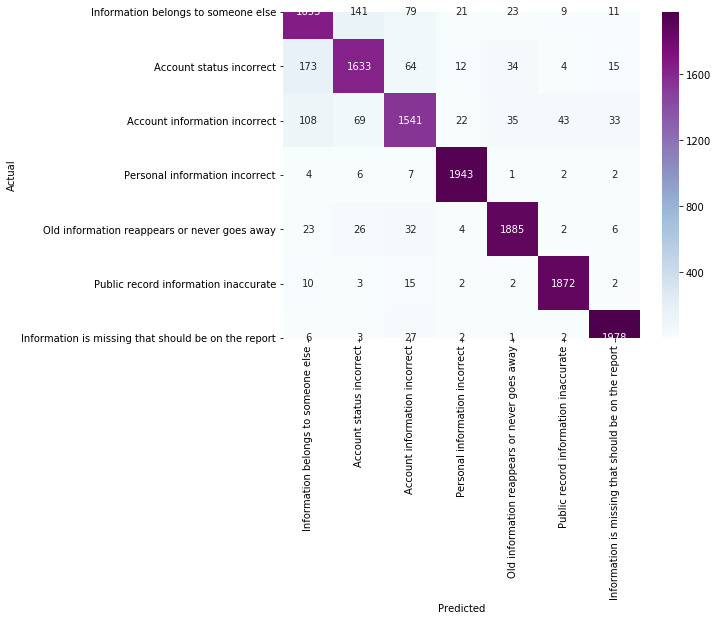

In [35]:
conf_mat = confusion_matrix(y_test, final_svc_predict)
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(conf_mat, annot = True, fmt = "d", cmap = "BuPu",xticklabels = df_clean['sub_issue'].unique(),yticklabels = df_clean['sub_issue'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [36]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
print(sklearn.metrics.classification_report(y_test, final_svc_predict.round(),target_names=df_clean['sub_issue'].unique()))

                                                     precision    recall  f1-score   support

                Information belongs to someone else       0.84      0.85      0.84      1939
                           Account status incorrect       0.87      0.84      0.86      1935
                      Account information incorrect       0.87      0.83      0.85      1851
                     Personal information incorrect       0.97      0.99      0.98      1965
       Old information reappears or never goes away       0.95      0.95      0.95      1978
               Public record information inaccurate       0.97      0.98      0.97      1906
Information is missing that should be on the report       0.97      0.98      0.97      2019

                                           accuracy                           0.92     13593
                                          macro avg       0.92      0.92      0.92     13593
                                       weighted avg       0.92      

# Pre-trained word embeddings

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df_clean.body, df_clean.sub_issue, test_size=0.25,random_state=0,shuffle=True)

In [38]:
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = array(y_train)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_encoded = onehot_encoder.fit_transform(integer_encoded)
print(y_encoded)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [39]:
values_0 = array(y_test)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values_0)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_encoded_test = onehot_encoder.fit_transform(integer_encoded)
print(y_encoded_test)

[[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [40]:
all_words=' '.join(x_train)
all_words=word_tokenize(all_words)

dist=FreqDist(all_words)

num_unique_word=len(dist)
num_unique_word

14259

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_unique_word) 
tokenizer.fit_on_texts(x_train)

x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [42]:
num_tokens = [len(tokens) for tokens in x_train_tokens]
num_tokens = np.array(num_tokens)
np.max(num_tokens)

2635

In [43]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

254

In [44]:
#This covers about 96% of the data-set.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9604403367280862

In [45]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,padding=pad, truncating=pad)

In [46]:
print('Shape of x train:', x_train_pad.shape)
print('Shape of t train:', y_encoded.shape)

Shape of x train: (16987, 254)
Shape of t train: (16987, 7)


In [47]:
print('Shape of x train:', x_test_pad.shape)
print('Shape of t train:', y_encoded_test.shape)

Shape of x train: (5663, 254)
Shape of t train: (5663, 7)


In [48]:
import os
from keras.utils import to_categorical
from tensorflow.keras.layers import Input, RepeatVector
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
GLOVE_DIR = 'C:/Users/licor/OneDrive/Desktop/qmss/glove/glove.6B.100d.txt'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR), encoding="utf8")

In [50]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [53]:
word_index = tokenizer.word_index
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [54]:
embedding_matrix.shape

(14259, 100)

In [55]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_tokens,
                            trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(7, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=['acc'])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 254, 100)          1425900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 128)           512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 128)          

In [59]:
7265/sum(y_encoded)

array([ 2.22171254,  2.18037215,  1.        , 18.82124352,  7.74520256,
        8.09921962,  8.08120133])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [60]:
class_weight = {0 : 2.24732184, 1 : 2.16270731, 2 : 1., 3 : 19.1468254, 4 : 7.5390625, 5 : 7.78225806, 6 : 8.39130435}

In [61]:
history = model.fit(x_train_pad, y_encoded,
 batch_size=32,
 epochs=10,
 class_weight = class_weight,
 validation_split = 0.1)

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15288 samples, validate on 1699 samples
Epoch 1/10
15288/15288 [==============================] - 33s 2ms/step - loss: 6.0528 - acc: 0.2174 - val_loss: 4.9906 - val_acc: 0.1948
Epoch 2/10
15288/15288 [==============================] - 34s 2ms/step - loss: 4.7980 - acc: 0.3814 - val_loss: 4.4339 - val_acc: 0.3390
Epoch 3/10
15288/15288 [==============================] - 34s 2ms/step - loss: 4.4503 - acc: 0.4259 - val_loss: 4.5366 - val_acc: 0.3131
Epoch 4/10
15288/15288 [==============================] - 35s 2ms/step - loss: 4.2439 - acc: 0.4557 - val_loss: 4.7011 - val_acc: 0.3614
Epoch 5/10
15288/15288 [==============================] - 35s 2ms/step - loss: 4.1748 - acc: 0.4668 - val_loss: 4.1933 - val_acc: 0.4726
Epoch 6/10
15288/15288 [==============================] - 35s 2ms/step - loss: 3.9732 - acc: 0.4815 - val_loss: 4.3048 - val_acc: 0.5044
Epoch 7/10
15288/15288 [==============================] - 39s 3ms/step - loss: 3.8908 - acc: 0.4961 - val_loss: 4.3264 - val_acc:

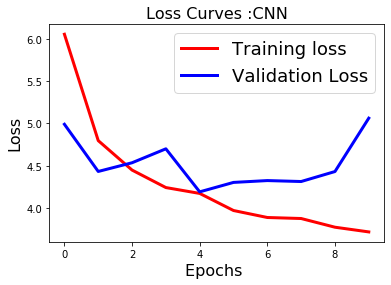

In [62]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

In [63]:
predicted=model.predict(x_test_pad)
predicted

array([[6.90290555e-02, 3.21983621e-02, 5.03392220e-01, ...,
        1.52416065e-01, 1.40798781e-02, 2.44907383e-03],
       [8.05435926e-02, 4.54845503e-02, 6.50364816e-01, ...,
        1.79257303e-01, 1.69675436e-03, 3.89414345e-04],
       [1.62239820e-01, 8.72331634e-02, 4.40511048e-01, ...,
        9.58310142e-02, 1.97300427e-02, 6.63602026e-03],
       ...,
       [2.07700804e-01, 1.87138438e-01, 2.49039344e-02, ...,
        1.52333602e-01, 2.65349261e-03, 1.94823614e-03],
       [3.80617380e-02, 1.53355692e-02, 9.21947122e-01, ...,
        1.60703417e-02, 7.77744455e-04, 6.02796488e-03],
       [5.48651293e-02, 2.35294234e-02, 1.57594562e-01, ...,
        1.04457445e-01, 1.12700732e-02, 1.18824665e-03]], dtype=float32)

In [64]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
print(sklearn.metrics.classification_report(y_encoded_test, predicted.round(),target_names=df_clean['sub_issue'].unique()))

                                                     precision    recall  f1-score   support

                Information belongs to someone else       0.46      0.01      0.02      1070
                           Account status incorrect       0.62      0.18      0.28      1107
                      Account information incorrect       0.94      0.46      0.62      2444
                     Personal information incorrect       0.06      0.85      0.11       135
       Old information reappears or never goes away       0.36      0.34      0.35       321
               Public record information inaccurate       0.75      0.67      0.71       323
Information is missing that should be on the report       0.82      0.45      0.58       263

                                          micro avg       0.45      0.34      0.39      5663
                                          macro avg       0.57      0.42      0.38      5663
                                       weighted avg       0.72      

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM

In [65]:
inp = Input(shape=(max_tokens, ))
x = Embedding(len(tokenizer.word_index) + 1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.10)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.10)(x)
x = Dense(7, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 254)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 254, 100)          1425900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 254, 120)          77280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                6050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0   

In [66]:
history = model.fit(x_train_pad, y_encoded,
 batch_size=32,
 epochs=10,
 class_weight = class_weight,
 validation_data= (x_test_pad, y_encoded_test))

Train on 16987 samples, validate on 5663 samples
Epoch 1/10
16987/16987 [==============================] - 139s 8ms/step - loss: 4.5945 - accuracy: 0.4525 - val_loss: 1.3710 - val_accuracy: 0.4994
Epoch 2/10
16987/16987 [==============================] - 147s 9ms/step - loss: 3.7748 - accuracy: 0.5540 - val_loss: 1.2024 - val_accuracy: 0.5679
Epoch 3/10
16987/16987 [==============================] - 150s 9ms/step - loss: 3.5362 - accuracy: 0.5790 - val_loss: 1.1203 - val_accuracy: 0.5947
Epoch 4/10
16987/16987 [==============================] - 150s 9ms/step - loss: 3.3231 - accuracy: 0.5938 - val_loss: 1.1015 - val_accuracy: 0.6069
Epoch 5/10
16987/16987 [==============================] - 154s 9ms/step - loss: 3.1749 - accuracy: 0.6040 - val_loss: 1.0838 - val_accuracy: 0.6039
Epoch 6/10
16987/16987 [==============================] - 152s 9ms/step - loss: 3.0378 - accuracy: 0.6147 - val_loss: 1.0289 - val_accuracy: 0.6149
Epoch 7/10
16987/16987 [==============================] - 153s 

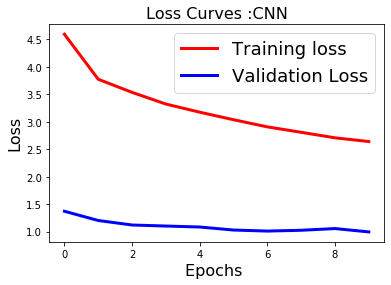

In [67]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

In [68]:
predicted=model.predict(x_test_pad)
print(sklearn.metrics.classification_report(y_encoded_test, predicted.round(),target_names=df_clean['sub_issue'].unique()))

                                                     precision    recall  f1-score   support

                Information belongs to someone else       0.76      0.17      0.28      1070
                           Account status incorrect       0.64      0.41      0.50      1107
                      Account information incorrect       0.91      0.69      0.79      2444
                     Personal information incorrect       0.28      0.47      0.35       135
       Old information reappears or never goes away       0.48      0.48      0.48       321
               Public record information inaccurate       0.70      0.82      0.76       323
Information is missing that should be on the report       0.61      0.70      0.65       263

                                          micro avg       0.74      0.53      0.62      5663
                                          macro avg       0.63      0.54      0.54      5663
                                       weighted avg       0.76      

C:\Users\licor\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
